In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image directories and labels

In [63]:

positive_dir = Path('../dataset/Positive')
negative_dir = Path('../dataset/Negative')

# Generate DataFrames
positive_df = pd.DataFrame({
    'Filepath': [str(fp) for fp in positive_dir.glob('*.jpg')],
    'Label': 'POSITIVE'
})

negative_df = pd.DataFrame({
    'Filepath': [str(fp) for fp in negative_dir.glob('*.jpg')],
    'Label': 'NEGATIVE'
})

# Concatenate the DataFrames and shuffle the rows
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

# Display the resulting DataFrame
print(all_df)


                              Filepath     Label
0        ..\dataset\Positive\03842.jpg  POSITIVE
1      ..\dataset\Positive\12899_1.jpg  POSITIVE
2      ..\dataset\Positive\15033_1.jpg  POSITIVE
3        ..\dataset\Negative\16782.jpg  NEGATIVE
4        ..\dataset\Positive\09202.jpg  POSITIVE
...                                ...       ...
39995    ..\dataset\Positive\07814.jpg  POSITIVE
39996    ..\dataset\Negative\12512.jpg  NEGATIVE
39997    ..\dataset\Positive\05193.jpg  POSITIVE
39998  ..\dataset\Positive\12173_1.jpg  POSITIVE
39999    ..\dataset\Negative\13004.jpg  NEGATIVE

[40000 rows x 2 columns]


# Split the DataFrame into training and testing sets
# - `train_size`: 70% for training, 30% for testing
# - `shuffle`: True to shuffle the data
# - `random_state`: Set for reproducibility

In [64]:

train_df, test_df = train_test_split(
    all_df,
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# Display the resulting DataFrames
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())


Training DataFrame:
                              Filepath     Label
8224     ..\dataset\Negative\10266.jpg  NEGATIVE
11219  ..\dataset\Positive\17009_1.jpg  POSITIVE
17353    ..\dataset\Negative\17992.jpg  NEGATIVE
15305    ..\dataset\Negative\18270.jpg  NEGATIVE
30147    ..\dataset\Negative\10938.jpg  NEGATIVE

Testing DataFrame:
                              Filepath     Label
3841     ..\dataset\Negative\09109.jpg  NEGATIVE
12898  ..\dataset\Positive\11681_1.jpg  POSITIVE
15032    ..\dataset\Negative\01233.jpg  NEGATIVE
36781    ..\dataset\Negative\12374.jpg  NEGATIVE
9201     ..\dataset\Negative\12888.jpg  NEGATIVE


# Define image data generators for training and testing


In [65]:

# Specify image dimensions
image_size = (120, 120)

# Define data generators for training, validation, and testing

## Training data generator
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of the data will be used for validation
)

train_data = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',  
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'  # Use the training subset of the data
)

## Validation data generator
val_data = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'  # Use the validation subset of the data
)

## Testing data generator
test_data_gen = ImageDataGenerator(
    rescale=1./255
)

test_data = test_data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,  # No need to shuffle for testing
    seed=42
)


Found 22400 validated image filenames belonging to 2 classes.
Found 5600 validated image filenames belonging to 2 classes.
Found 12000 validated image filenames belonging to 2 classes.


# Define the model architecture

In [62]:

# Define the input shape
input_shape = (120, 120, 3)


## Input layer
inputs = tf.keras.Input(shape=input_shape)

## Convolutional layers
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

## Global Average Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

## Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
print(model.summary())


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 59, 59, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_4   (None, 32)               0   

# Train the model

In [53]:

## Specify training parameters
epochs = 100

## Set up EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Monitor validation loss for early stopping
    patience=3,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

## Train the model
history = model.fit(
    train_data,                 # Training data generator
    validation_data=val_data,   # Validation data generator
    epochs=epochs,              # Number of training epochs
    callbacks=[early_stopping_callback]  # List of callbacks, including EarlyStopping
)


Epoch 1/100
700/700 [==============================] - 404s 577ms/step - loss: 0.4582 - accuracy: 0.8103 - val_loss: 0.2436 - val_accuracy: 0.9129
Epoch 2/100
700/700 [==============================] - 67s 96ms/step - loss: 0.1496 - accuracy: 0.9594 - val_loss: 0.1065 - val_accuracy: 0.9695
Epoch 3/100
700/700 [==============================] - 69s 98ms/step - loss: 0.0929 - accuracy: 0.9727 - val_loss: 0.0975 - val_accuracy: 0.9798
Epoch 4/100
700/700 [==============================] - 68s 97ms/step - loss: 0.0749 - accuracy: 0.9770 - val_loss: 0.0683 - val_accuracy: 0.9755
Epoch 5/100
700/700 [==============================] - 70s 101ms/step - loss: 0.0692 - accuracy: 0.9775 - val_loss: 0.0625 - val_accuracy: 0.9793
Epoch 6/100
700/700 [==============================] - 68s 97ms/step - loss: 0.0634 - accuracy: 0.9792 - val_loss: 0.0629 - val_accuracy: 0.9827
Epoch 7/100
700/700 [==============================] - 72s 103ms/step - loss: 0.0647 - accuracy: 0.9797 - val_loss: 0.0564 - va

In [61]:
model.save("model.h5")

# Display validation and accuracy graphs.

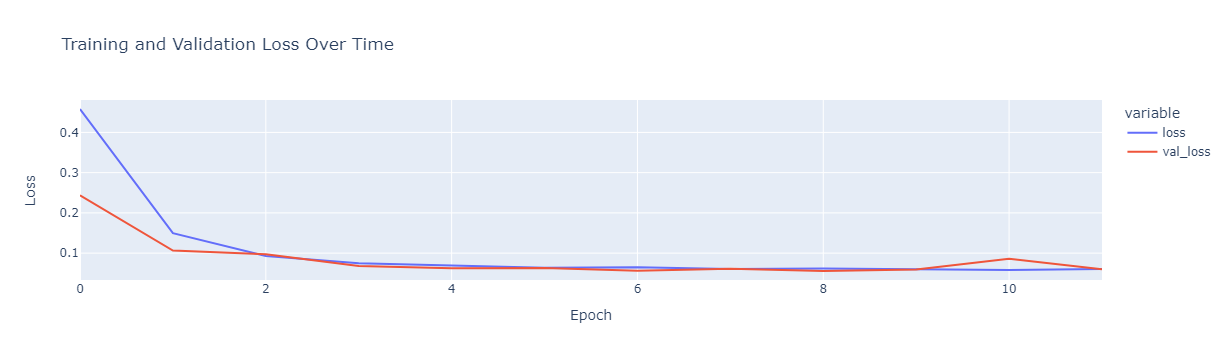

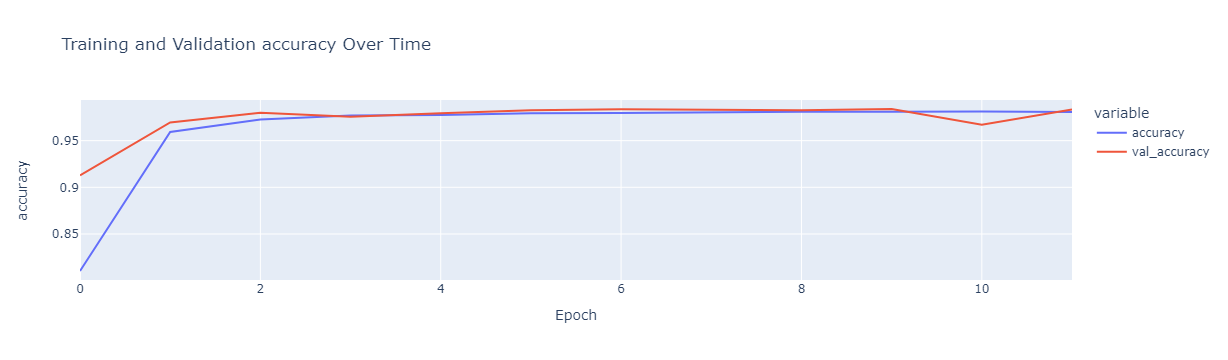

In [59]:
loss_fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

loss_fig.show()

fig = px.line(
    history.history,
    y=['accuracy', 'val_accuracy'],
    labels={'index': "Epoch", 'value': "accuracy"},
    title="Training and Validation accuracy Over Time"
)

fig.show()

In [ ]:
model = load_model('model.h5')

# Display confusion matrix and classification report

    Test Loss: 0.05889
Test Accuracy: 98.05%
375/375 [==============================] - 24s 63ms/step


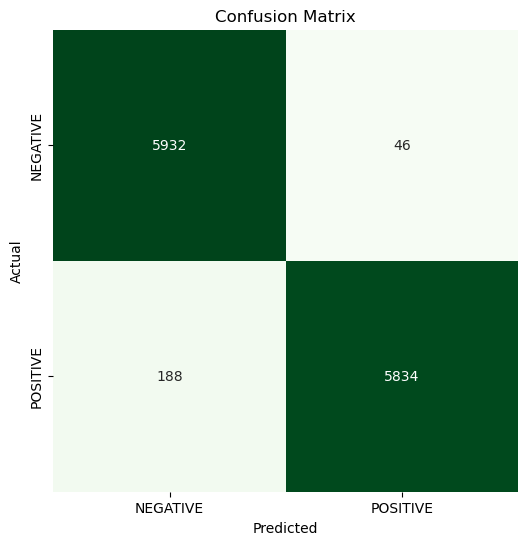

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98      5978
    POSITIVE       0.99      0.97      0.98      6022

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [60]:
def evaluate_model(model, test_data):

    # Evaluate the model on the test data
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    # Print test loss and accuracy
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    # Generate predictions and calculate confusion matrix and classification report
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

    # Visualize confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:\n----------------------\n", clr)
    
evaluate_model(model, test_data)